In [1]:
import os
os.environ['SETIGEN_ENABLE_GPU'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from astropy import units as u
import blimpy as bl
import setigen as stg

bshuf filter already loaded, skip it.


In [2]:
%matplotlib inline

In [3]:
output_dir = "/datax/scratch/bbrzycki/data/raw_files/"

In [6]:
def NB_inject(ip_file_stem, SNR,drift_rate, num_branches,f_start,f_stop,num_signals,op_file_stem ):
    
    start_chan = 0
    raw_params = stg.voltage.get_raw_params(input_file_stem=ip_file_stem, start_chan=start_chan)
    sample_rate=raw_params['chan_bw']*num_branches # chan_bw = sample_rate / num_branches to keep this constant 
    print('sample rate', sample_rate)
    num_taps=8
    

    print('\n input file parameters: \n ',raw_params)
    
    antenna = stg.voltage.Antenna(sample_rate=sample_rate, **raw_params)
    
    

    filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                                 num_branches=num_branches)

    rvb = stg.voltage.RawVoltageBackend.from_data(input_file_stem=ip_file_stem,
                                                  antenna_source=antenna,
                                                  filterbank=filterbank,
                                                  start_chan=start_chan,
                                                  num_subblocks=128)

    
    assert f_start> rvb.fch1 and f_stop< rvb.fch1+rvb.chan_bw*rvb.num_chans, 'injection frequencies not in range '

#     print('\n Antenna noise std',antenna.x.get_total_noise_std())

    fftlength = 8192
    # num blocks
#     nb = 3
    nb=stg.voltage.get_total_blocks(ip_file_stem)
    
    print('\n total blocks in the file', nb)
    
    signal_level = stg.voltage.get_level(snr=SNR,
                                raw_voltage_backend=rvb,
                                fftlength=fftlength,
    #                             obs_length=4.652881237333333,
    #                             length_mode='obs_length'
                                num_blocks=nb,
                                length_mode='num_blocks'
                                        )

    print('\nsignal level ', signal_level)
    
#     df = chan_bw / fftlength

    for n_sig, fstart in enumerate(np.linspace(f_start, f_stop, num_signals)):
#         fstart = int(fstart - raw_params[])
        leakage_factor = stg.voltage.get_leakage_factor(fstart, rvb, fftlength)
        print(f'{fstart/1e6:.4f} MHz leakage factor: {leakage_factor:.3f}')

        for stream in antenna.streams:
            # There's actually no noise present, but we set levels assuming a background noise_std of 1
            level = 1 * leakage_factor * signal_level #* (n_sig + 1)
            print('level: ',level)
            stream.add_constant_signal(f_start=fstart, 
                                       drift_rate=drift_rate*u.Hz/u.s, 
                                       level=1*level)
    
    print('unit drift rate corres. 1x1 pixel in final data',stg.voltage.get_unit_drift_rate(rvb, fftlength, 1))
            
    rvb.record(output_file_stem=op_file_stem,
               num_blocks=nb, 
               length_mode='num_blocks',
              header_dict={'TELESCOP': 'GMRT', 'OBSERVER': 'AE' , 'SRC_NAME' : '7202'},
               digitize=False,
               verbose=False)
    
    !rawspec -f 8192 -t 1 -d /datax/scratch/bbrzycki/data/raw_files/ /datax/scratch/bbrzycki/data/raw_files/inj_573_50
    
ip_file_stem='/home/eakshay/amity/raghav/GSB_iFFT_pipeline/PASV_to_GUPPI/TEST_padding_v2_guppi'
SNR=10000
drift_rate=0   
num_branches=4096
f_start=561.5e6
f_stop=563.5e6
num_signals=20
op_file_stem='/datax/scratch/bbrzycki/data/raw_files/inj_573_50'

NB_inject(ip_file_stem, SNR, drift_rate, num_branches,f_start,f_stop,num_signals,op_file_stem )

wf = bl.Waterfall('/datax/scratch/bbrzycki/data/raw_files/inj_573_50.rawspec.0000.fil',
                  f_start=561,
                  f_stop=564)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spectrum = stg.integrate(frame, normalize=True)

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.yscale('symlog')
plt.show()

sample rate 50000000.0

 input file parameters: 
  {'num_bits': 8, 'chan_bw': 12207.03125, 'ascending': True, 'num_pols': 1, 'block_size': 134217728, 'obs_length': 22.0, 'tbin': 8.192e-05, 'num_antennas': 1, 'num_chans': 2048, 'center_freq': 562500000.0, 'fch1': 550006103.515625}


OutOfMemoryError: Out of memory allocating 2,619,342,848 bytes (allocated so far: 7,318,734,848 bytes).

In [6]:
12207.03125/8192, frame.df

(1.4901161193847656, 1.4901161193847656)

In [7]:
spectrum = stg.integrate(frame, normalize=True)
spectrum.shape

(2013266,)

In [10]:
2048*12207.03125/1e6

25.0

blimpy.io.base_reader WARNING  Setting data limit != 1GB, please handle with care!


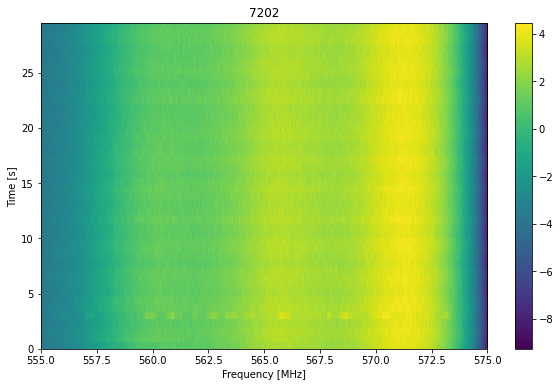

In [8]:
wf = bl.Waterfall('/datax/scratch/bbrzycki/data/raw_files/inj_573_50.rawspec.0000.fil',
                  f_start=555,
                  f_stop=575,
                  max_load=10)
plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

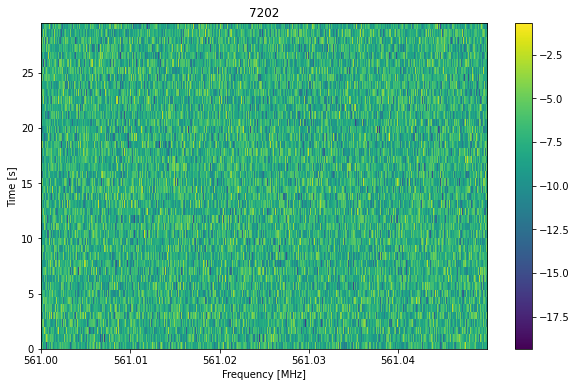

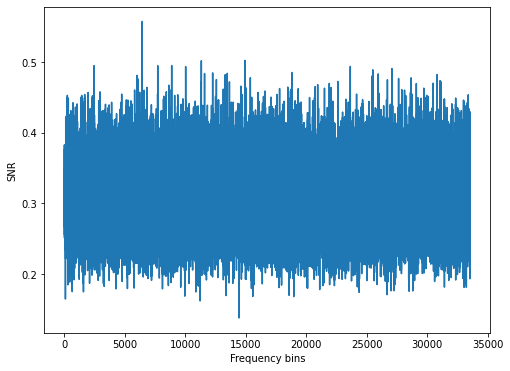

In [16]:
wf = bl.Waterfall('/datax/scratch/bbrzycki/data/raw_files/inj_573_50.rawspec.0000.fil',
                  f_start=561,
                  f_stop=561.05,
                  max_load=1)
frame = stg.Frame(wf)
plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()


spectrum = stg.integrate(frame, normalize=False)

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.show()

In [23]:
bl.Waterfall('/datax/scratch/bbrzycki/data/raw_files/blc00_guppi_59114_15868_TMC1_0010.rawspec.0000.fil').header

blimpy.io.base_reader WARNING  Selection size of 4.00 GB, exceeding our size limit 1.00 GB. Instance created, header loaded, but data not loaded, please try another (t,v) selection.


{'machine_id': 20,
 'telescope_id': 6,
 'src_raj': <Angle 4.69605333 hourangle>,
 'src_dej': <Angle 25.6911 deg>,
 'az_start': 0.0,
 'za_start': 0.0,
 'data_type': 1,
 'fch1': 25813.96484375,
 'foff': -2.7939677238464355e-06,
 'nchans': 67108864,
 'nbeams': 1,
 'ibeam': -1,
 'nbits': 32,
 'tstart': 59114.183657407404,
 'tsamp': 1.431655765333332,
 'nifs': 1,
 'source_name': 'TMC1',
 'rawdatafile': 'blc00_guppi_59114_15868_TMC1_0010.0000.raw'}

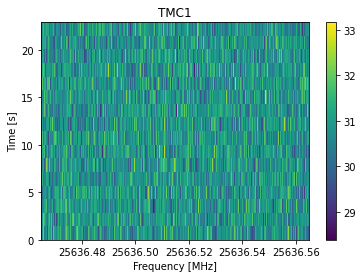

(16, 35791)

In [26]:
frame = stg.Frame('/datax/scratch/bbrzycki/data/raw_files/blc00_guppi_59114_15868_TMC1_0010.rawspec.0000.fil',
                 f_start=25636.464844,
                 f_stop=25636.564844)
frame.bl_plot()
plt.show()
frame.shape

In [21]:
frame.df

1.4901161193847656

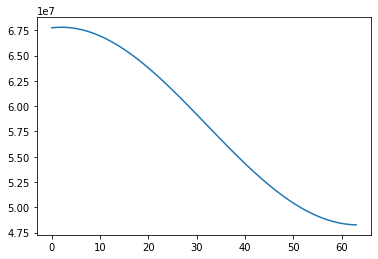

In [20]:
filterbank = stg.voltage.PolyphaseFilterbank(num_taps=2, 
                                             num_branches=4096)
plt.plot(filterbank.response)

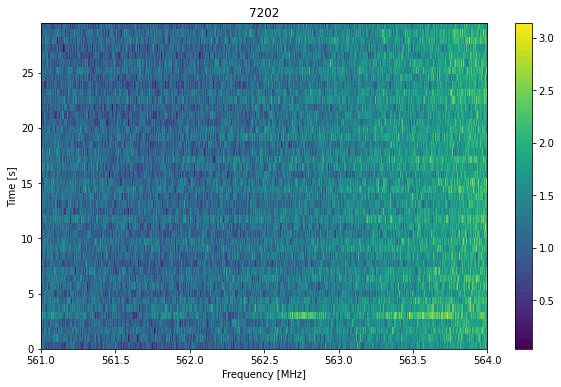

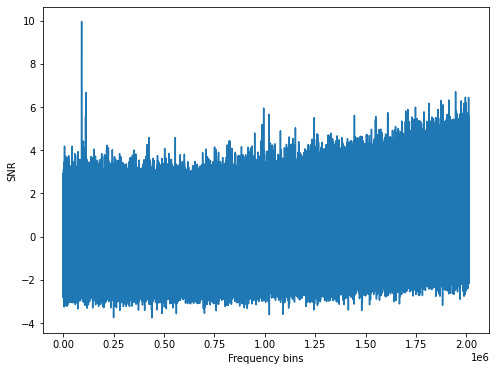

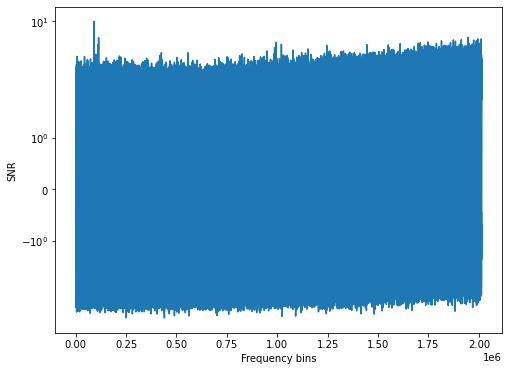

In [4]:
wf = bl.Waterfall('/datax/scratch/bbrzycki/data/raw_files/inj_573_50.rawspec.0000.fil',
                  f_start=561,
                  f_stop=564)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spectrum = stg.integrate(frame, normalize=True)

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.yscale('symlog')
plt.show()

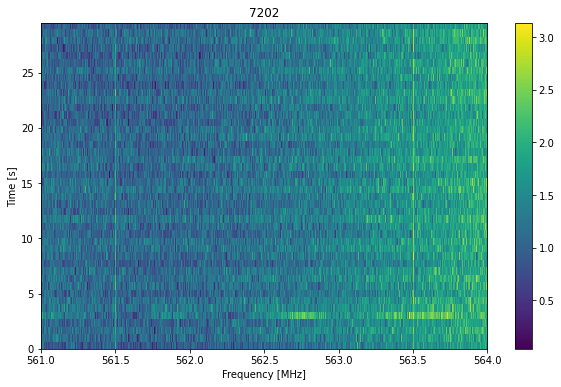

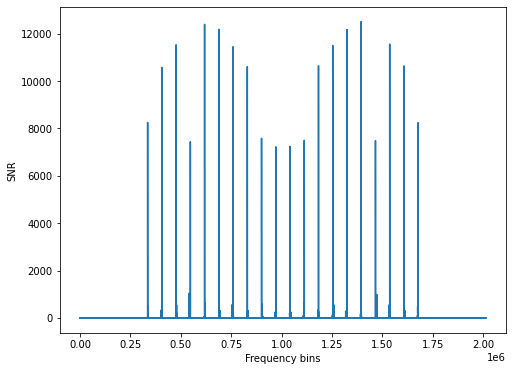

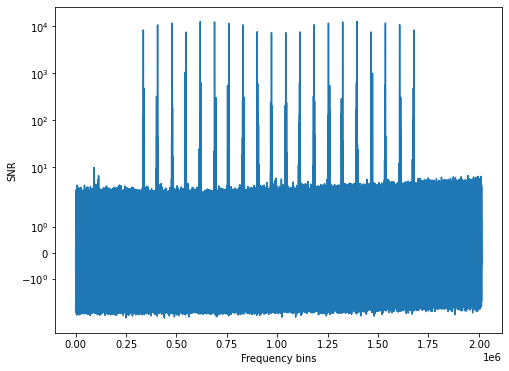

In [4]:
wf = bl.Waterfall('/datax/scratch/bbrzycki/data/raw_files/inj_573_50.rawspec.0000.fil',
                  f_start=561,
                  f_stop=564)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spectrum = stg.integrate(frame, normalize=True)

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.yscale('symlog')
plt.show()

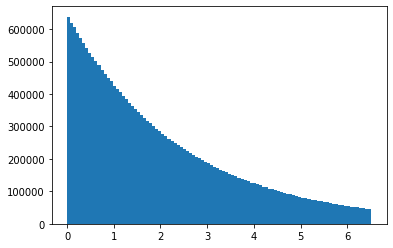

In [9]:

from astropy.stats import sigma_clip
plt.hist(sigma_clip(frame.data.flatten()), bins=100)
plt.show()

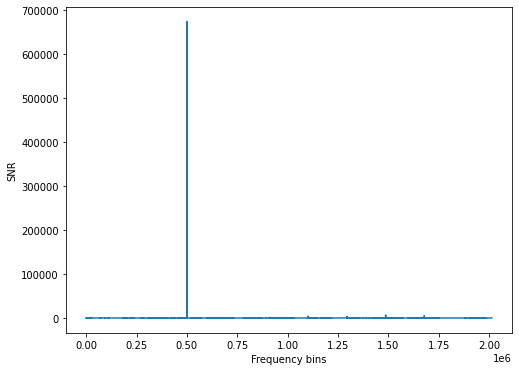

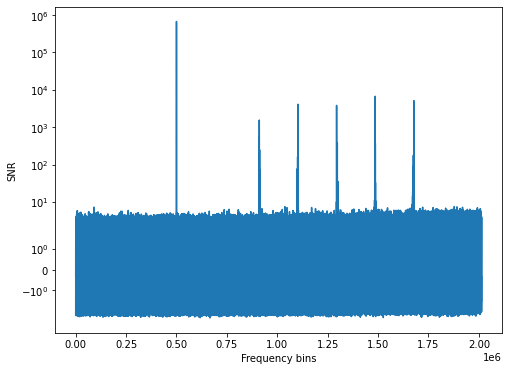

In [10]:
frame.add_constant_signal(f_start=frame.get_frequency(500000),
                          drift_rate=0,
                          level=frame.get_intensity(snr=1e6),
                          width=40*u.Hz,
                          f_profile_type='sinc2')

spectrum = stg.integrate(frame, normalize=True)

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.yscale('symlog')
plt.show()

In [11]:
frame.chi2_df

4.0

In [12]:
frame.noise_mean

1.9539478